# Final for Eco 723 - Time Series

Using data from the S&P/BVL Peru General Index, I fit a GARCH (1,1) model to forecast volatility and compute a 
VaR Backtest Report using the R library "rugarch".

In [1]:
library(tseries)
library(zoo)
library(forecast)
library("FinTS")
library(rugarch)

Warning message:
"package 'tseries' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Warning message:
"package 'zoo' was built under R version 3.6.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'forecast' was built under R version 3.6.3"Warning message:
"package 'FinTS' was built under R version 3.6.3"
Attaching package: 'FinTS'

The following object is masked from 'package:forecast':

    Acf

Warning message:
"package 'rugarch' was built under R version 3.6.3"Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:stats':

    sigma



# Data

I get 5 years worth of data of from the S&P/BVL Peru General Index

The S&P/BVL Peru General Index, is the main index of the Lima Stock Exchange. It is designed to serve as a broad benchmark for the Peruvian stock market, tracking the performance of the largest and most frequently traded stocks on the Lima Exchange.

The data is obtained from yahoo, from May 2013 to May 2018


In [2]:
bvl <- get.hist.quote(instrument = "^SPBLPGPT" , start = "2013-05-01", end = "2018-05-02", quote ="Adjusted",provider = "yahoo",compression = "d" , retclass = "zoo")

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.

Warning message:
"^SPBLPGPT contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."

time series starts 2013-05-02
time series ends   2018-05-01


In [3]:
# I take a quick look at the data.
str(bvl)
head(bvl)
tail(bvl)

'zoo' series from 2013-05-02 to 2018-05-01
  Data: num [1:1259, 1] 17448 17652 17706 17408 17575 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr "Adjusted"
  Index:  Date[1:1259], format: "2013-05-02" "2013-05-03" "2013-05-06" "2013-05-07" "2013-05-08" ...


           Adjusted
2013-05-02 17447.61
2013-05-03 17652.27
2013-05-06 17706.34
2013-05-07 17408.11
2013-05-08 17575.32
2013-05-09 17812.75

           Adjusted
2018-04-24 21504.17
2018-04-25 21357.15
2018-04-26 21467.14
2018-04-27 21411.73
2018-04-30 21431.16
2018-05-01       NA

In [4]:
bvl <- na.omit(bvl) # I get rid of NA values, and look at the data once more.
str(bvl)
head(bvl)
tail(bvl)

'zoo' series from 2013-05-02 to 2018-04-30
  Data: num [1:1220, 1] 17448 17652 17706 17408 17575 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr "Adjusted"
 - attr(*, "na.action")= 'omit' num [1:39] 61 85 111 129 243 252 312 313 363 405 ...
  Index:  Date[1:1220], format: "2013-05-02" "2013-05-03" "2013-05-06" "2013-05-07" "2013-05-08" ...


           Adjusted
2013-05-02 17447.61
2013-05-03 17652.27
2013-05-06 17706.34
2013-05-07 17408.11
2013-05-08 17575.32
2013-05-09 17812.75

           Adjusted
2018-04-23 21516.09
2018-04-24 21504.17
2018-04-25 21357.15
2018-04-26 21467.14
2018-04-27 21411.73
2018-04-30 21431.16

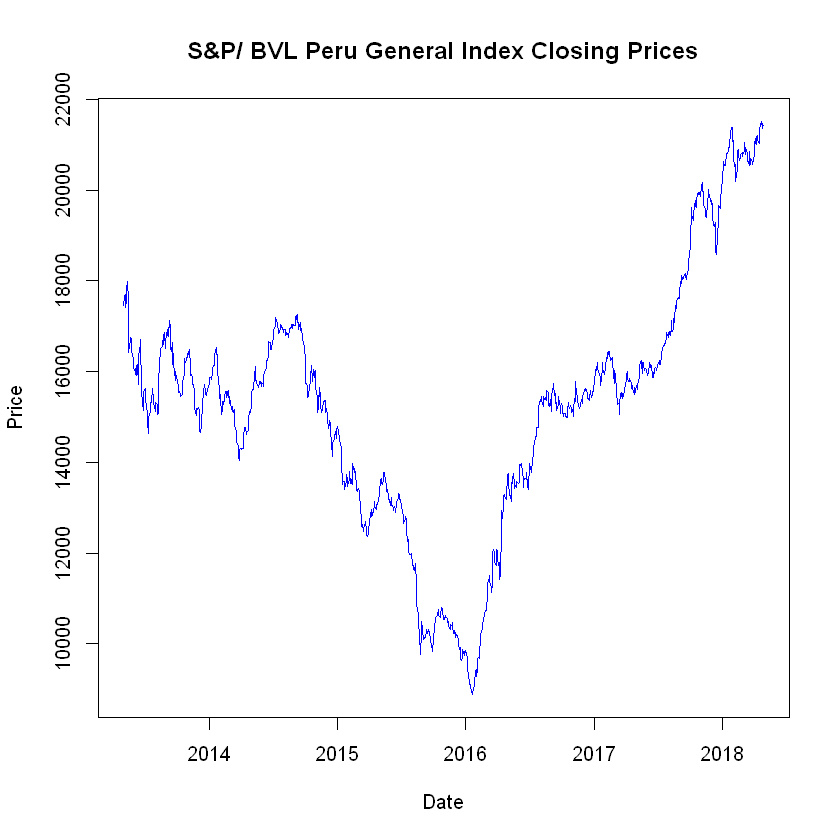

In [5]:
# I plot the series. 
plot(bvl , main = "S&P/ BVL Peru General Index Closing Prices", ylab = "Price", xlab = "Date", col ="blue")

In [6]:
# I compute daily log returns of the series. 
returns <- diff(log(bvl))*100 
# The diff function computes the difference between pairs of consecutive elements of a numeric vector.
head(returns)

              Adjusted
2013-05-03  1.16617197
2013-05-06  0.30583983
2013-05-07 -1.69866050
2013-05-08  0.95595093
2013-05-09  1.34188300
2013-05-10 -0.06384624

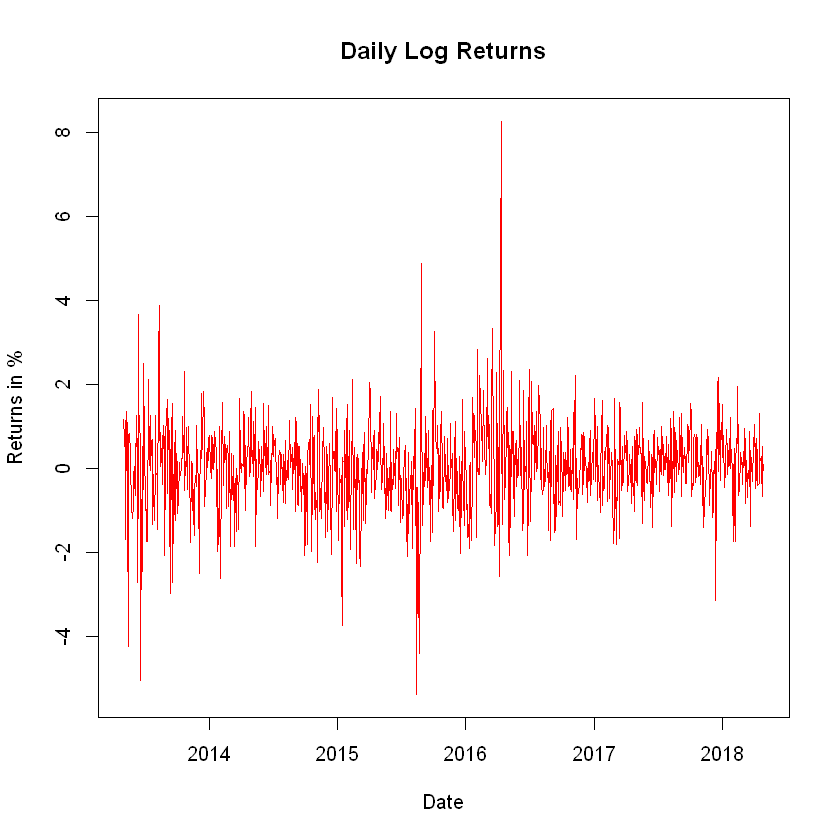

In [7]:
plot(returns, main = "Daily Log Returns", ylab = "Returns in %", xlab = "Date", col ="red")

# Methods

In [8]:
# Before fitting the GARCH model, one must specify an ARMA(p,q) model
fit1  <- auto.arima(returns, trace = T, test = "kpss", ic = "bic")


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : Inf
 ARIMA(0,1,0) with drift         : 4287.012
 ARIMA(1,1,0) with drift         : 4059.118
 ARIMA(0,1,1) with drift         : Inf
 ARIMA(0,1,0)                    : 4280.572
 ARIMA(2,1,0) with drift         : 4146.043
 ARIMA(1,1,1) with drift         : Inf
 ARIMA(2,1,1) with drift         : Inf
 ARIMA(1,1,0)                    : 4055.064
 ARIMA(2,1,0)                    : 4139.686
 ARIMA(1,1,1)                    : Inf
 ARIMA(0,1,1)                    : Inf
 ARIMA(2,1,1)                    : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,1,0)                    : 3830.941

 Best model: ARIMA(1,1,0)                    



In [9]:
# The best model suggested was an ARIMA (1,1,0). As a result, we differenced the series one more time.
returns <- diff(returns, 1)

In [10]:
fit2 <- auto.arima(returns, trace = T, test = "kpss", ic = "bic")
# this time around the best model suggested was ARIMA (1,0,0) or also an ARMA (1,0) or an AR (1).


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -83017.26
 ARIMA(0,0,0) with non-zero mean : 3958.287
 ARIMA(1,0,0) with non-zero mean : 3761.1
 ARIMA(0,0,1) with non-zero mean : Inf
 ARIMA(0,0,0) with zero mean     : 3951.183
 ARIMA(1,0,2) with non-zero mean : Inf
 ARIMA(2,0,1) with non-zero mean : -80981.56
 ARIMA(3,0,2) with non-zero mean : Inf
 ARIMA(2,0,3) with non-zero mean : Inf
 ARIMA(1,0,1) with non-zero mean : Inf
 ARIMA(1,0,3) with non-zero mean : Inf
 ARIMA(3,0,1) with non-zero mean : -76935.31
 ARIMA(3,0,3) with non-zero mean : Inf
 ARIMA(2,0,2) with zero mean     : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(2,0,1) with non-zero mean : Inf
 ARIMA(3,0,1) with non-zero mean : Inf
 ARIMA(1,0,0) with non-zero mean : 3795.71

 Best model: ARIMA(1,0,0) with non-zero mean 



In [11]:
# A Box-Ljung test, as well as a ARCH LM test is performed on the series. Both nulls are rejects and we proceed to fit 
# specify the GARCH model. 

Box.test(fit2$residuals^2, lag = 1 ,type = "Ljung-Box")
ArchTest(returns)



	Box-Ljung test

data:  fit2$residuals^2
X-squared = 50.067, df = 1, p-value = 1.486e-12



	ARCH LM-test; Null hypothesis: no ARCH effects

data:  returns
Chi-squared = 202.96, df = 12, p-value < 2.2e-16


In [12]:
# I specify a GARCH(1,1) and an ARMA(1,0), based on the auto.arima function from before.
specify <- ugarchspec(variance.model = list(garchOrder = c(1,1)), mean.model = list(armaOrder = c(1,0)))

# Results

In [13]:
# The model is fitted
fit <- ugarchfit(spec = specify, data = returns)
show(fit)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.008584    0.017970  -0.47766 0.632894
ar1    -0.407627    0.027721 -14.70454 0.000000
omega   0.112160    0.041623   2.69470 0.007045
alpha1  0.170583    0.035376   4.82198 0.000001
beta1   0.742093    0.060986  12.16824 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.008584    0.008171  -1.0504 0.293523
ar1    -0.407627    0.024342 -16.7462 0.000000
omega   0.112160    0.071645   1.5655 0.117464
alpha1  0.170583    0.056423   3.0233 0.002501
beta1   0.742093    0.107768   6.8860 0.000000

LogLikelihood : -1783.137 

Information Criteria
------------------------------------
         

In [14]:
# The VaR Backtest Report is computed at aplha .01

roll <- ugarchroll( specify, returns, n.start = 120, refit.every = 1, refit.window = "moving", solver = "hybrid", calculate.VaR = TRUE, VaR.alpha = c(0.01,.05), keep.coef = TRUE, fit.control = list(scale = 1))
report(roll, type = "VaR", VaR.alpha = 0.01, conf.level = 0.99)

VaR Backtest Report
Model:				sGARCH-norm
Backtest Length:	1098
Data:				

alpha:				1%
Expected Exceed:	11
Actual VaR Exceed:	15
Actual %:			1.4%

Unconditional Coverage (Kupiec)
Null-Hypothesis:	Correct Exceedances
LR.uc Statistic:	1.334
LR.uc Critical:		6.635
LR.uc p-value:		0.248
Reject Null:		NO

Conditional Coverage (Christoffersen)
Null-Hypothesis:	Correct Exceedances and
					Independence of Failures
LR.cc Statistic:	1.75
LR.cc Critical:		9.21
LR.cc p-value:		0.417
Reject Null:		NO



please wait...calculating quantiles...


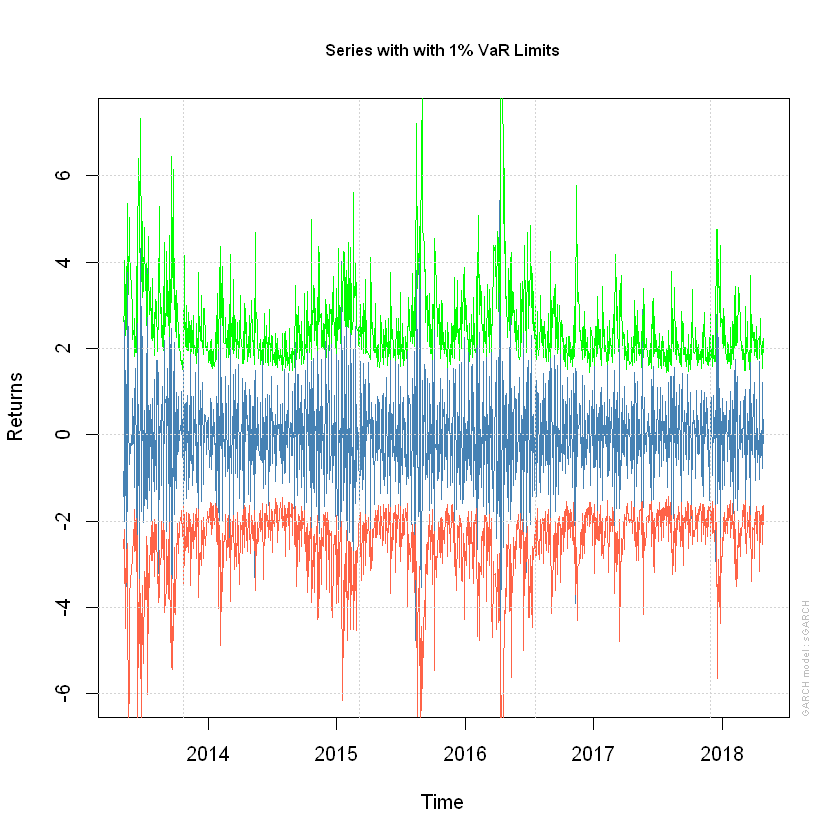

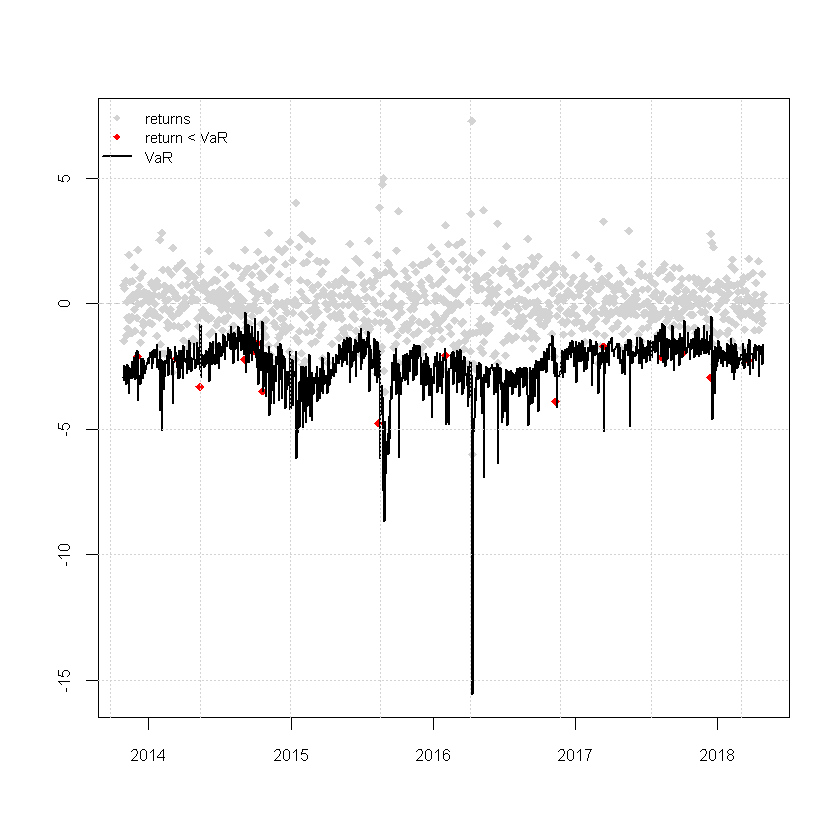

In [15]:
plot(fit, which = 2)
plot(roll, which = 4, VaR.alpha = 0.01)

In [16]:
# We forecast volatility for the next 60 days
forecast <- ugarchforecast(fit, n.ahead = 60)
forecast


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 60
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=2018-04-30]:
        Series  Sigma
T+1  -0.154406 0.7923
T+2   0.050858 0.8277
T+3  -0.032813 0.8587
T+4   0.001293 0.8861
T+5  -0.012610 0.9104
T+6  -0.006942 0.9320
T+7  -0.009253 0.9513
T+8  -0.008311 0.9685
T+9  -0.008695 0.9840
T+10 -0.008538 0.9979
T+11 -0.008602 1.0105
T+12 -0.008576 1.0218
T+13 -0.008587 1.0320
T+14 -0.008582 1.0413
T+15 -0.008584 1.0496
T+16 -0.008583 1.0572
T+17 -0.008584 1.0641
T+18 -0.008584 1.0703
T+19 -0.008584 1.0759
T+20 -0.008584 1.0811
T+21 -0.008584 1.0857
T+22 -0.008584 1.0900
T+23 -0.008584 1.0938
T+24 -0.008584 1.0973
T+25 -0.008584 1.1005
T+26 -0.008584 1.1034
T+27 -0.008584 1.1061
T+28 -0.008584 1.1085
T+29 -0.008584 1.1107
T+30 -0.008584 1.1127
T+31 -0.008584 1.1145
T+32 -0.008584 1.1161
T+33 -0.008584 1.1177
T+34 -0.008584 1.1190
T+35 -0.008584 1.1203

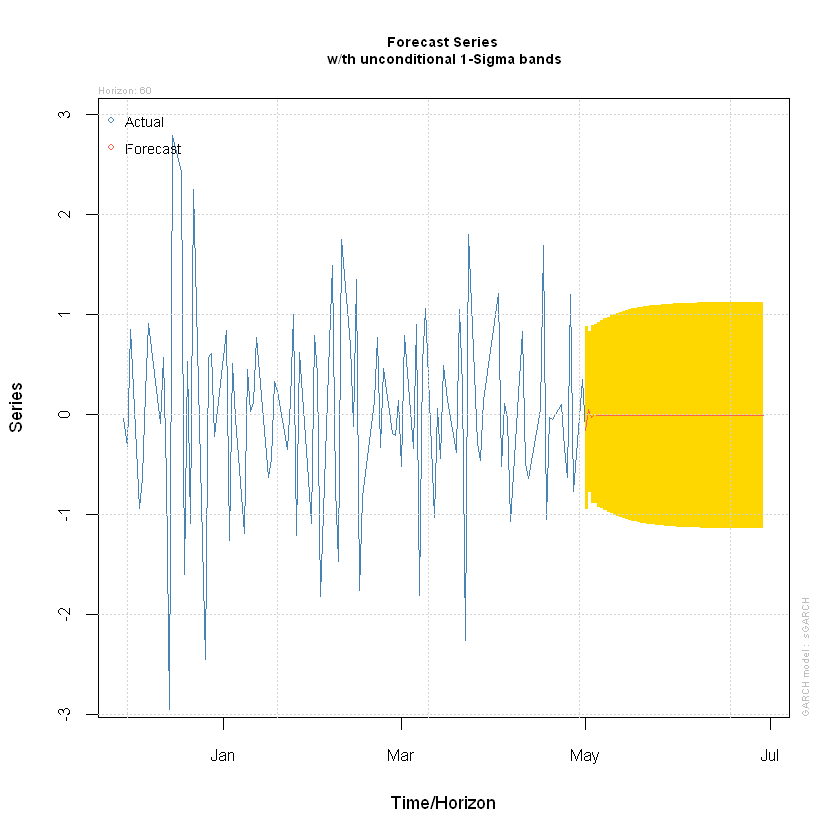

In [17]:
plot(forecast, which = 1) 

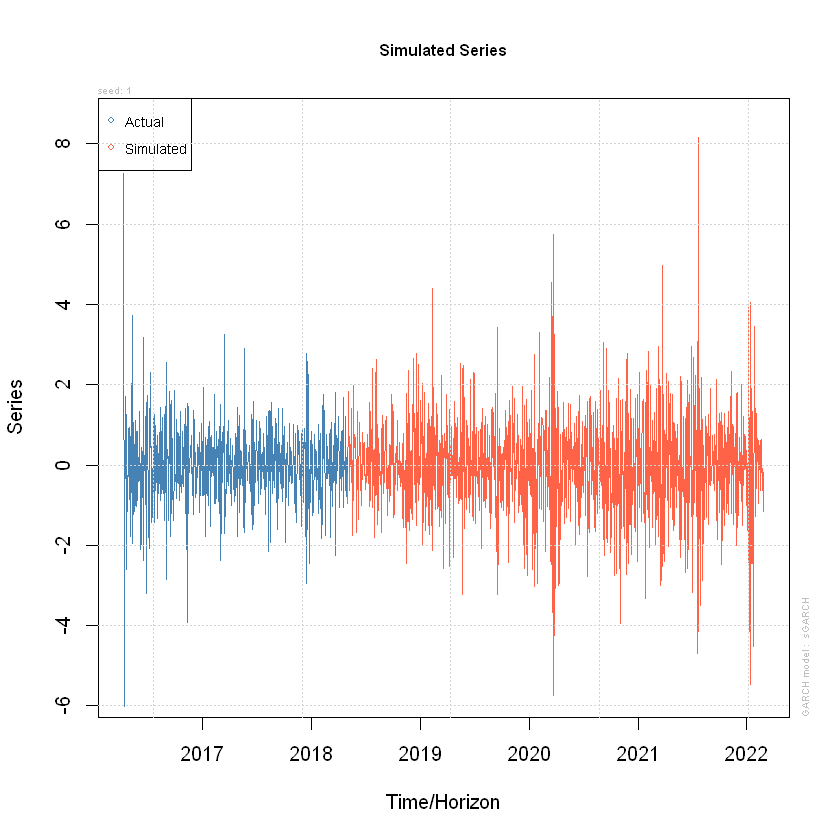

In [18]:
# We simulate volatilty for the 1000 days

sim = ugarchsim(fit, n.sim = 1000, m.sim = 25, rseed = 1:25)
plot(sim, which =2)